In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
from tqdm import tqdm
from PIL import Image
os.getcwd()
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.2.0


In [2]:
#Ref: https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.optimizers import SGD
import pandas as pd
import numpy as np
import keras 
from keras.layers import *
from keras.models import *

traindf=pd.read_csv('train.csv',dtype=str)
testdf=pd.read_csv('test.csv',dtype=str)

traindf['age']=traindf.age.astype('int64')

testdf['age']=traindf.age.astype('int64')

print(traindf.head())
print(testdf.head())

print(traindf.info())
print(testdf.info())


Using TensorFlow backend.


                                           full_path gender  age
0  data/imdb/50/nm0004950_rm4036071168_1972-4-17_...      0   38
1  data/imdb/77/nm0004977_rm474265344_1973-7-15_2...      1   37
2  data/imdb/21/nm0019221_rm3640760320_1948-9-11_...      1   16
3  data/imdb/34/nm1289434_rm2872508160_1983-2-23_...      0   32
4  data/imdb/90/nm0001590_rm687003392_1952-5-15_2...      1   57
                                           full_path gender  age
0  data/imdb/44/nm0089244_rm238668800_1939-8-7_19...      0   38
1          data/wiki/21/32518421_1991-09-01_2015.jpg      1   37
2          data/wiki/76/38687576_1939-08-29_1961.jpg      1   16
3  data/imdb/88/nm0005388_rm594123264_1970-5-15_2...      1   32
4  data/imdb/25/nm0001325_rm2254805248_1959-11-3_...      1   57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156918 entries, 0 to 156917
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   full_path  156918 non-nul

In [3]:
test_labels = testdf['age']
print(test_labels)

0        38
1        37
2        16
3        32
4        57
         ..
52561    20
52562    49
52563    24
52564    29
52565    41
Name: age, Length: 52566, dtype: int64


In [4]:
#train and validation data generators

img_dim=128


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
#        rotation_range=90,
#        shear_range=0.2,
#        horizontal_flip=True,
#        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age'],
subset="training",
#try a smaller batch size                                            
batch_size=32,
seed=42,
shuffle=True,
class_mode='raw', 
target_size=(img_dim,img_dim))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age'],
subset="validation",
batch_size=1, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=True,
class_mode='raw',
target_size=(img_dim,img_dim))

Found 125535 validated image filenames.
Found 31383 validated image filenames.


In [5]:
#test data generator

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=None,
x_col='full_path',
y_col=None,
batch_size=1, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_dim,img_dim))




Found 52566 validated image filenames.


In [6]:
#Define model

inputs = Input(shape = (img_dim,img_dim, 3))

# Begin
model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides= 2, activation='relu', input_shape=(img_dim, img_dim, 3))(inputs)
#model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides= 2, input_shape=(img_dim, img_dim, 3))(inputs)
model = MaxPool2D(pool_size=(3, 3), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(model)
model=Flatten()(model)

age_model = Dense(256, activation='relu')(model)
age_model = Dropout(0.4)(age_model)
age_model = Dense(512, activation='relu')(age_model)
age_model = Dropout(0.4)(age_model)
age_model= Dense(1, activation='linear',name='age')(age_model)


In [7]:
model = Model(inputs=inputs, outputs=age_model)
#lower lr as the same number was been predicted regardless of the input
model.compile(optimizer = tf.keras.optimizers.Adam(0.002), loss ='mse',metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       7385

In [8]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)]


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=callbacks)



Epoch 1/10
 633/3922 [===>..........................] - ETA: 27:50 - loss: 682.1661 - mae: 13.2141

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarnin

 935/3922 [======>.......................] - ETA: 25:15 - loss: 526.8721 - mae: 12.4938

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 1. 
  warnings.warn(str(msg))


1664/3922 [===========>..................] - ETA: 19:03 - loss: 381.9355 - mae: 11.7862

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


1779/3922 [============>.................] - ETA: 18:09 - loss: 370.5264 - mae: 11.7388

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


1802/3922 [============>.................] - ETA: 17:57 - loss: 368.2649 - mae: 11.7265

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


1986/3922 [==============>...............] - ETA: 16:24 - loss: 351.6912 - mae: 11.6295

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2081741501 bytes but only got 0. Skipping tag 40191
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1070775869 bytes but only got 0. Skipping tag 38460
  " Skipping tag %s" % (size, len(data), tag)


2215/3922 [===============>..............] - ETA: 14:28 - loss: 335.3000 - mae: 11.5370

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 5. 
  warnings.warn(str(msg))


2490/3922 [==================>...........] - ETA: 12:07 - loss: 319.5698 - mae: 11.4530

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


2727/3922 [===================>..........] - ETA: 10:07 - loss: 308.9626 - mae: 11.4037

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 7. 
  warnings.warn(str(msg))


3311/3922 [========================>.....] - ETA: 5:10 - loss: 288.1438 - mae: 11.2782

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 266 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)


3921/3922 [============================>.] - ETA: 0s - loss: 273.1137 - mae: 11.1912

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 278 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4721482732 bytes but only got 0. Skipping tag 35839
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 9. 
  warnings.warn(str(msg))


3922/3922 [==============================] - 2455s 626ms/step - loss: 273.0779 - mae: 11.1906 - val_loss: 1257.8875 - val_mae: 12.2337
Epoch 2/10
3922/3922 [==============================] - 2457s 626ms/step - loss: 176.3746 - mae: 10.2564 - val_loss: 135.7376 - val_mae: 12.8982
Epoch 3/10
3922/3922 [==============================] - 2469s 630ms/step - loss: 156.7979 - mae: 9.6466 - val_loss: 2.8727 - val_mae: 9.6135
Epoch 4/10
3922/3922 [==============================] - 2480s 632ms/step - loss: 146.9660 - mae: 9.3547 - val_loss: 29.1643 - val_mae: 9.1610
Epoch 5/10
3922/3922 [==============================] - 2487s 634ms/step - loss: 140.9036 - mae: 9.1680 - val_loss: 2.8353 - val_mae: 9.5631
Epoch 6/10
3922/3922 [==============================] - 2491s 635ms/step - loss: 134.9305 - mae: 8.9558 - val_loss: 12.1408 - val_mae: 9.5672
Epoch 7/10
3922/3922 [==============================] - 2492s 635ms/step - loss: 129.4379 - mae: 8.7693 - val_loss: 19.8939 - val_mae: 8.7476
Epoch 8/10
3

In [9]:
model.save('cnn_age_model.h5')
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


/Users/varuni/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


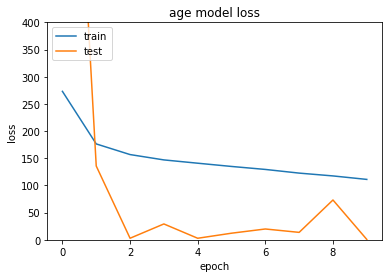

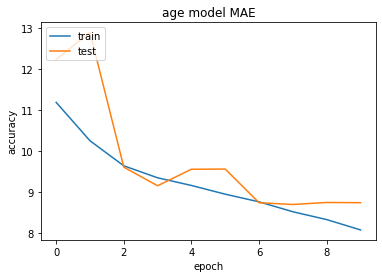

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 400])
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_only_MSE.png')
plt.clf()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('age model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_only_MAE.png')
plt.clf()

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,loss,mae,epoch
5,12.140789,9.567200,134.930330,8.955828,5
6,19.893906,8.747582,129.437968,8.769300,6
7,13.677080,8.705027,122.683074,8.528028,7
8,73.231705,8.753992,117.506999,8.337317,8
9,0.700230,8.748919,111.100546,8.086040,9


In [12]:
#Evaluate
#loss, mae = model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)

#print("Testing set Mean Abs Error: {:5.2f}".format(mae))

In [13]:
# load model
new_model = load_model('cnn_age_model.h5')
# summarize model
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       7385

/Users/varuni/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
#Make predictions

test_generator.reset() #reset the test_generator before whenever you call the predict_generator
predictions=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

 2403/52566 [>.............................] - ETA: 12:38

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


11220/52566 [=====>........................] - ETA: 10:12

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16036032132 bytes but only got 0. Skipping tag 50687
  " Skipping tag %s" % (size, len(data), tag)


34088/52566 [==================>...........] - ETA: 4:36

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


52566/52566 [==============================] - 787s 15ms/step


In [16]:
print(predictions)

[[45.83603 ]
 [32.016655]
 [34.231445]
 ...
 [31.303028]
 [32.4001  ]
 [32.51051 ]]


In [18]:
test_predictions = predictions.flatten()
#.astype(int)
print(test_predictions)

[45.83603  32.016655 34.231445 ... 31.303028 32.4001   32.51051 ]


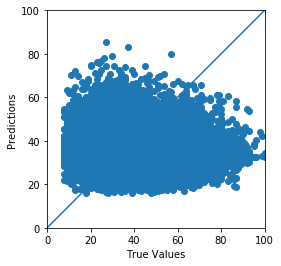

In [25]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

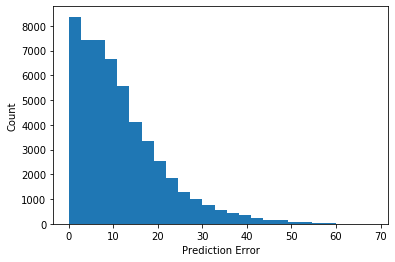

In [20]:
error = np.abs(test_predictions - test_labels)
#type(error)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [ ]:
#relu activation in the last layer gives a MAE of ~36

In [23]:
error.describe()

count    52566.000000
mean        11.646223
std          9.612493
min          0.000008
25%          4.489491
50%          9.426586
75%         16.253327
max         68.278755
Name: age, dtype: float64